In [1]:
from functools import reduce
from pathlib import Path
from collections import Counter
from dataclasses import dataclass

from fastai.basic_train import get_preds, LearnerCallback, Learner
from fastai.text import *
from fastai.datasets import *
from fastai.metrics import *
from fastai.train import *
from fastai.vision import *
from fastai.callback import Callback
from fastai.callbacks import SaveModelCallback
import pandas as pd

from fastai.imports import nn, torch
from sklearn import metrics
import sklearn.metrics
import altair as alt

import news_utils

%load_ext autoreload
%autoreload 2

alt.renderers.enable('notebook')
torch.cuda.set_device(2)

In [2]:
EX_PA = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/sentiment_maj/')
MODELS = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_models/')
LM_DATA_PATH = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_data/')

tokenizer = Tokenizer(special_cases = ['xxbos','xxfld','xxunk','xxpad', 'xxsep'])
# tokenizer = None

data_lm_train = pd.read_csv(LM_DATA_PATH/'train.csv')
data_lm_val = pd.read_csv(LM_DATA_PATH/'val.csv')

# Language model data
data_lm = TextLMDataBunch.from_df(LM_DATA_PATH, data_lm_train, data_lm_val, tokenizer=tokenizer)

In [3]:
data_clas_train = pd.read_csv(EX_PA/'train.csv')
data_clas_val = pd.read_csv(EX_PA/'val.csv')

data_clas = news_utils.RandomSampler.TextClasDataBunchRandom.from_df(EX_PA, data_clas_train, data_clas_val, vocab=data_lm.train_ds.vocab, bs=50, txt_cols=['text'], label_cols=['class'], num_samples=2000)

In [26]:
learn = language_model_learner(data_lm, pretrained_fnames=['lstm_wt103', 'itos_wt103'], drop_mult=0.5)

In [27]:
learn.fit_one_cycle(1, 1e-2)

Total time: 05:28
epoch  train_loss  valid_loss  accuracy
1      4.702953    4.542753    0.238456  (05:28)



In [28]:
# learn.load_encoder(MODELS/'ft_enc_05_30')
learn.unfreeze()
learn.fit_one_cycle(, 1e-3)

Total time: 06:23
epoch  train_loss  valid_loss  accuracy
1      4.388505    4.368560    0.254820  (06:23)



In [29]:
learn.save_encoder(MODELS/'06_11-_18')

In [3]:
# weights = [1,1, 1, 1]
# class_weights = torch.FloatTensor(weights).cuda()
# loss_func = nn.CrossEntropyLoss(weight=class_weights)



In [130]:
def f1(preds, y_true, x):
    _, y_pred = preds.max(dim=1)
    cpu_res = sklearn.metrics.f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro')
    return torch.tensor(cpu_res)

In [ ]:
f1s = []
learn2 = text_classifier_learner(data_clas, drop_mult=1)
learn2.metrics = []
learn2.load_encoder(MODELS/'ft_enc_05_30_continued')

# F1 score and save only best f1 macro score
@dataclass
class MyCallback(Callback):
    learn:Learner
    name:str='bestmodel'

    y_pred, y_true = [], []
    best = None
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        _, idxs = torch.max(last_output, 1)
        self.y_pred += idxs.tolist()
        self.y_true += last_target.tolist()
    
    
    def on_epoch_end(self, **kwargs):
        f1_macro = sklearn.metrics.f1_score(self.y_pred, self.y_true, average='macro')
        f1s.append(f1_macro)
        
#         save best
        if self.best is None or f1_macro > self.best:
            self.best = f1_macro
            self.learn.save(f'{self.name}')
        
#         not sure
        if len(self.learn.recorder.metrics) == 0:
            self.learn.recorder.metrics.append([])
        self.learn.recorder.metrics[0].append(f1_macro)
        if 'f1' not in self.learn.recorder.names:
            self.learn.recorder.names.append('f1')
            
    def on_train_end(self, **kwargs):
        self.learn.load(f'{self.name}')


learn2.callbacks += [MyCallback(learn2)]

learn2.fit(5000, 1e-3)
f1s

epoch,train_loss,valid_loss
1,1.383763,1.301764
2,1.346199,1.255851
3,1.335883,1.262042
4,1.329071,1.246166
5,1.335789,1.290374
6,1.326361,1.254829
7,1.318952,1.278949
8,1.308878,1.302777
9,1.307630,1.222493
10,1.300977,1.298416


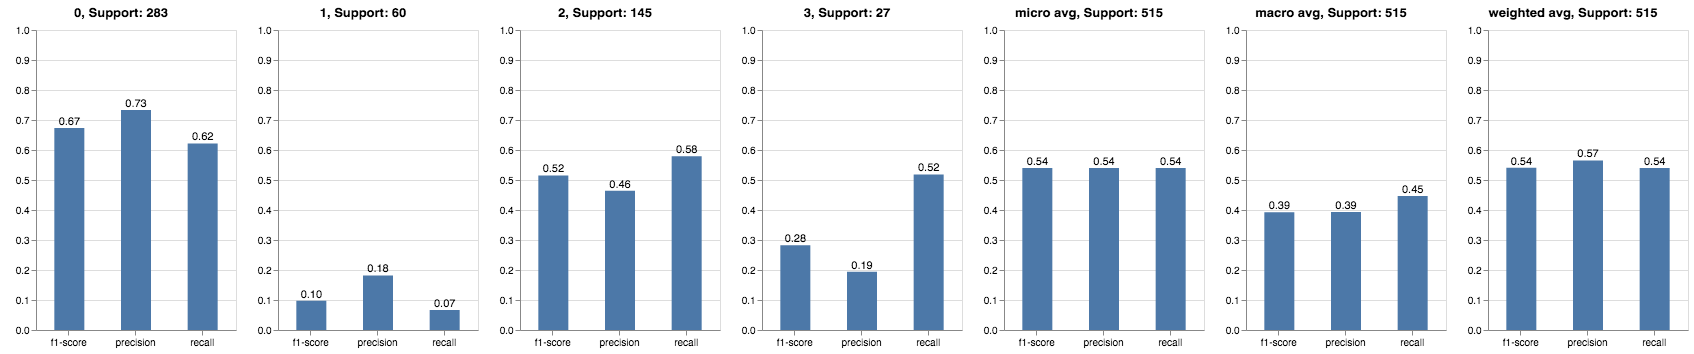

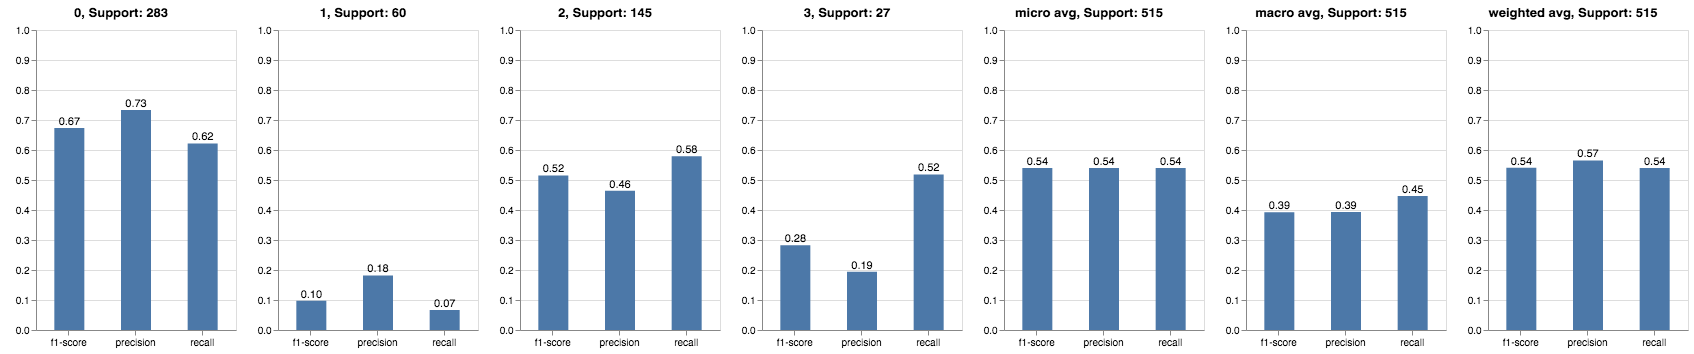

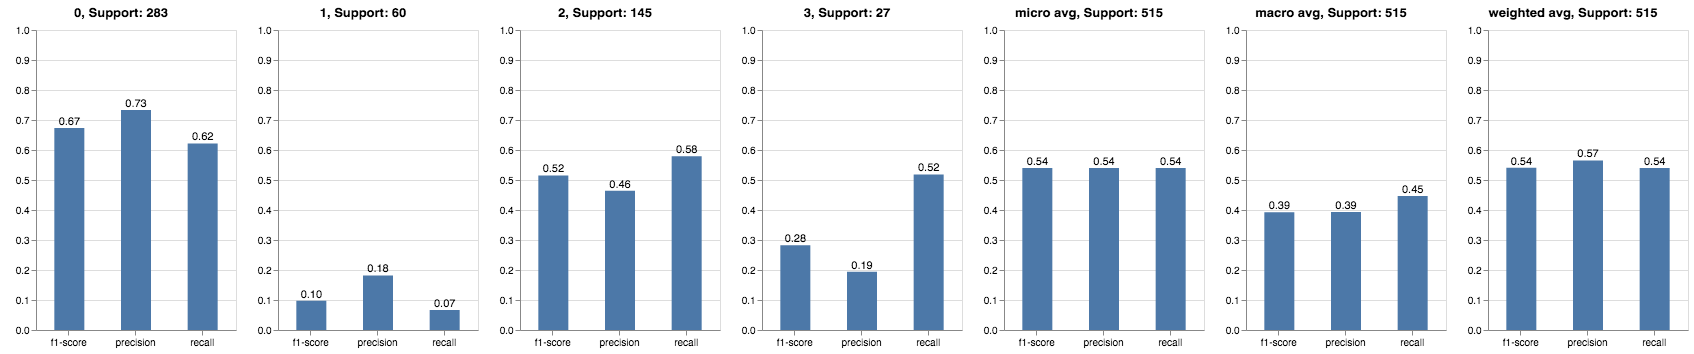

In [142]:
news_utils.plot.plot_class_report(learn3)

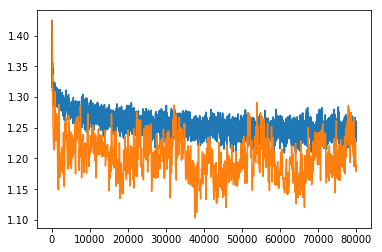

In [145]:
learn2.recorder.plot_losses()

In [123]:
learn2.recorder.add_metric_names('')

In [53]:
# while True:
learn2 = text_classifier_learner(data_clas, drop_mult=1)
learn2.load_encoder(MODELS/'ft_enc_05_30_continued')
learn2.fit(50, 1e-3)



Total time: 03:04
epoch  train_loss  valid_loss  accuracy
1      1.393902    1.341133    0.326214  (00:03)
2      1.358039    1.321823    0.382524  (00:03)
3      1.347168    1.329957    0.359223  (00:03)
4      1.342275    1.285238    0.436893  (00:03)
5      1.309989    1.246748    0.495146  (00:03)
6      1.314099    1.261769    0.483495  (00:03)
7      1.308837    1.261547    0.464078  (00:04)
8      1.315075    1.303712    0.425243  (00:03)
9      1.301528    1.277060    0.411651  (00:03)
10     1.310911    1.248235    0.467961  (00:03)
11     1.306735    1.262917    0.429126  (00:03)
12     1.298042    1.229011    0.473786  (00:03)
13     1.298247    1.241077    0.442718  (00:03)
14     1.303918    1.202577    0.497087  (00:04)
15     1.298948    1.206605    0.506796  (00:03)
16     1.305213    1.212729    0.495146  (00:03)
17     1.309604    1.233281    0.467961  (00:03)
18     1.303930    1.252492    0.450485  (00:04)
19     1.287041    1.186251    0.528155  (00:03)
20     1.30

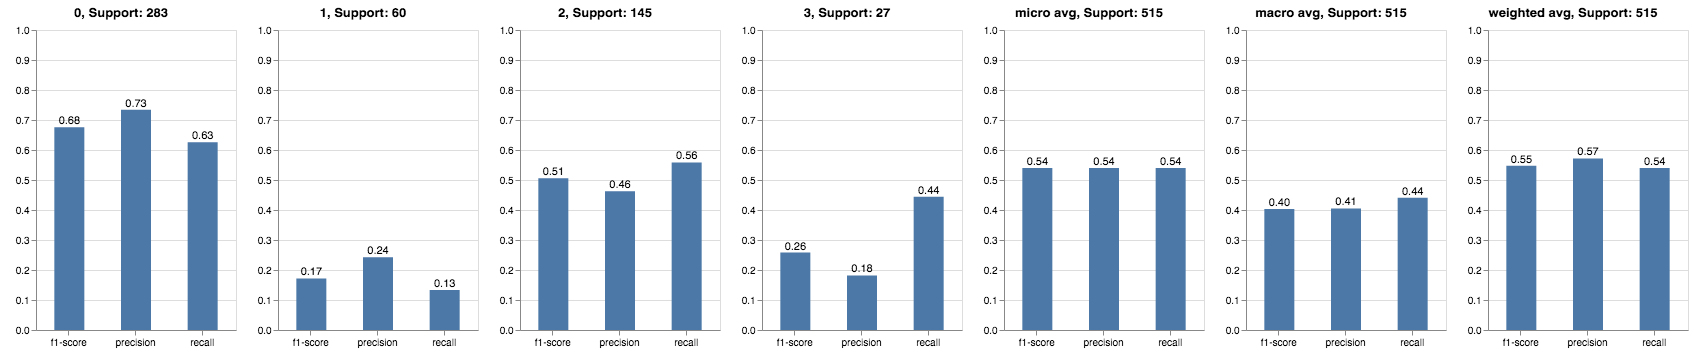

In [144]:
news_utils.plot.plot_class_report(learn2)

In [4]:
learn3 = text_classifier_learner(data_clas, drop_mult=1)


In [10]:
learn3.load('getreal')

In [11]:
learn3.get_preds()

[tensor([[0.2742, 0.2809, 0.2774, 0.1675],
         [0.1557, 0.2480, 0.5067, 0.0896],
         [0.4414, 0.2562, 0.1243, 0.1781],
         ...,
         [0.2756, 0.2297, 0.3286, 0.1660],
         [0.4054, 0.2532, 0.2177, 0.1237],
         [0.3922, 0.2157, 0.2631, 0.1289]]),
 tensor([0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 3, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0,
         0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 3, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 0, 3, 2, 2, 0, 1, 0, 2, 2, 2, 0, 0, 2,
         0, 0, 2, 3, 3, 0, 3, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0,
         0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 3, 0, 2,
         1, 0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 3,
         0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2,
         0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0,
         3, 0, 2, 2, 0, 2, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 3, 0, 2, 1, 0, 1, 

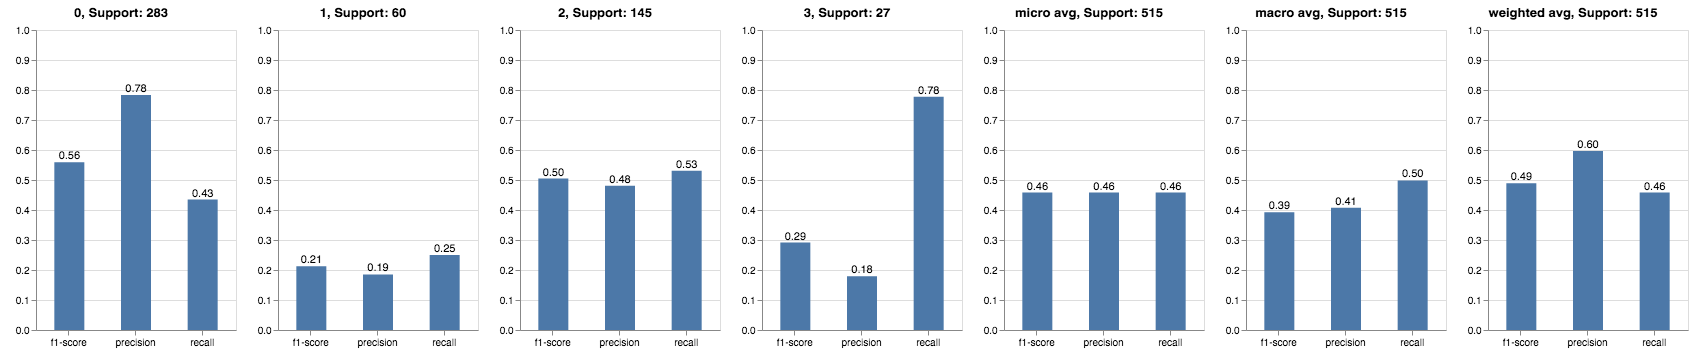

In [12]:
news_utils.plot.plot_class_report(learn3)